In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import statsmodels.tools as sm
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve
import scikitplot as skplt


#for not showing warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression

In [65]:
! pip install scikit-plot

In [66]:
data=pd.read_csv('data_modeling_10s_MIX.csv', index_col=0)


In [67]:
data=data.drop(columns=['id'])


In [68]:
data['intensity']=np.sqrt(data['x_mean']**2+data['y_mean']**2+data['z_mean']**2)/10
data['magnitude']=(data['x_mean']+data['y_mean']+data['z_mean'])/10
data['stdovermean1']=data['x_mean']/data['s1_std']
data['stdovermean2']=data['y_mean']/data['s1_std']
data['stdovermean3']=data['z_mean']/data['s1_std']

In [69]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 0 to 2407
Columns: 121 entries, s1_mean to stdovermean3
dtypes: float64(101), int64(18), object(2)
memory usage: 2.2+ MB


In [70]:
data.describe()


,s1_mean,s2_mean,s3_mean,x_mean,y_mean,z_mean,s1_variation,s2_variation,s3_variation,x_variation,...,y_peak_prom_stand,x_y_corr,z_y_corr,x_z_corr,Kg,intensity,magnitude,stdovermean1,stdovermean2,stdovermean3
count,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,...,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000
mean,67.333220,46.546945,54.093338,174.347082,32.872267,-865.023091,0.912361,2.313199,1.246932,4.887602,...,4.609469,-0.309089,0.012921,-0.169316,63.812168,128.544277,-65.780374,3.795051,1.167127,-33.110362
std,36.172414,29.077740,41.319862,114.281857,113.398885,950.715905,22.508131,38.511866,4.589454,8.101204,...,4.048368,0.441664,0.249078,0.329147,12.181424,23.832157,97.962802,12.867751,11.922553,84.463746
min,-17.090000,-15.403750,-15.337500,-531.967500,-508.355000,-2209.037500,-1098.141072,-140.899750,-115.726957,-231.225070,...,0.000000,-0.958914,-0.954300,-0.947648,52.000000,72.824999,-188.933250,-148.191302,-151.763990,-362.906654
25%,46.126559,27.452500,10.064509,97.859739,-69.785000,-1403.010476,1.096088,0.991677,0.419846,2.479409,...,0.000000,-0.640489,-0.137875,-0.404316,53.500000,102.567879,-117.231301,1.124048,-0.874795,-17.736953
50%,67.611523,47.252808,56.271644,176.081278,49.955206,-1227.791250,1.312785,1.345413,1.278816,4.645390,...,5.482471,-0.478998,0.030955,-0.281473,63.700000,133.178591,-98.548616,1.646823,0.571191,-12.165795
75%,90.984809,66.601562,74.254446,230.855360,114.811562,-982.281875,1.761023,1.876336,1.628066,6.478402,...,7.087208,-0.036298,0.181931,0.021127,63.700000,144.000239,-79.629000,3.568488,1.211837,-9.636322
max,238.155689,230.512974,302.381238,632.875000,603.715000,1741.845000,25.304658,1772.503879,137.673569,219.930945,...,24.857143,0.974355,0.940266,0.942150,89.200000,228.944748,218.399500,141.385988,169.956511,302.566483


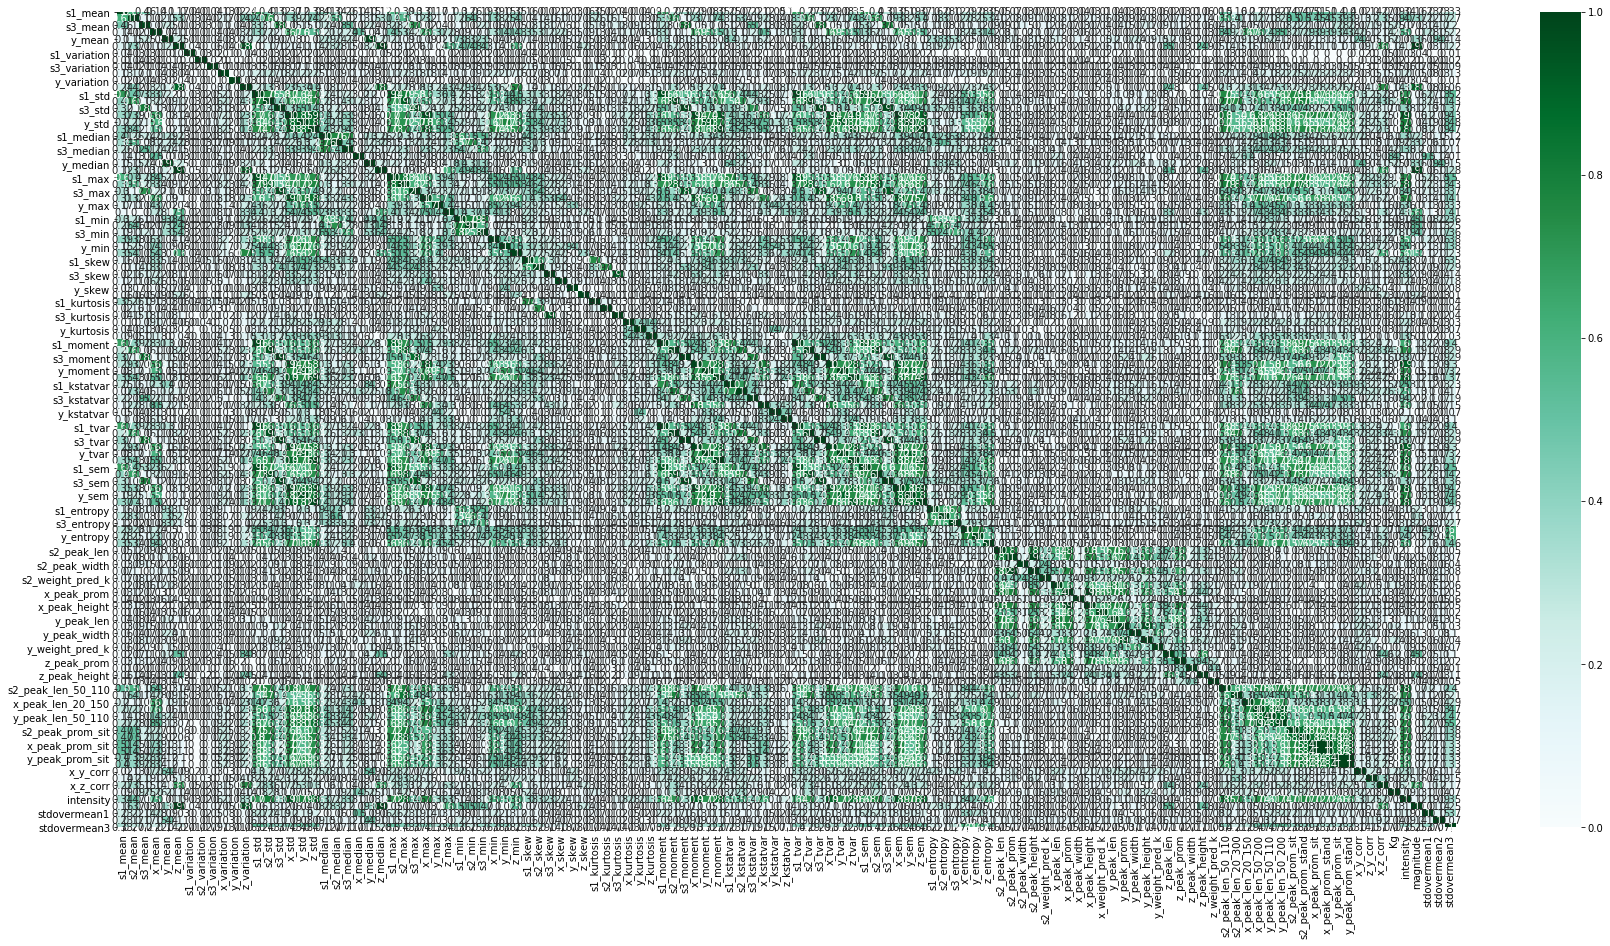

In [10]:
plt.figure(figsize=(30,15))
sns.heatmap(data.corr().abs().round(2),annot=True, cmap = "BuGn")
plt.show()

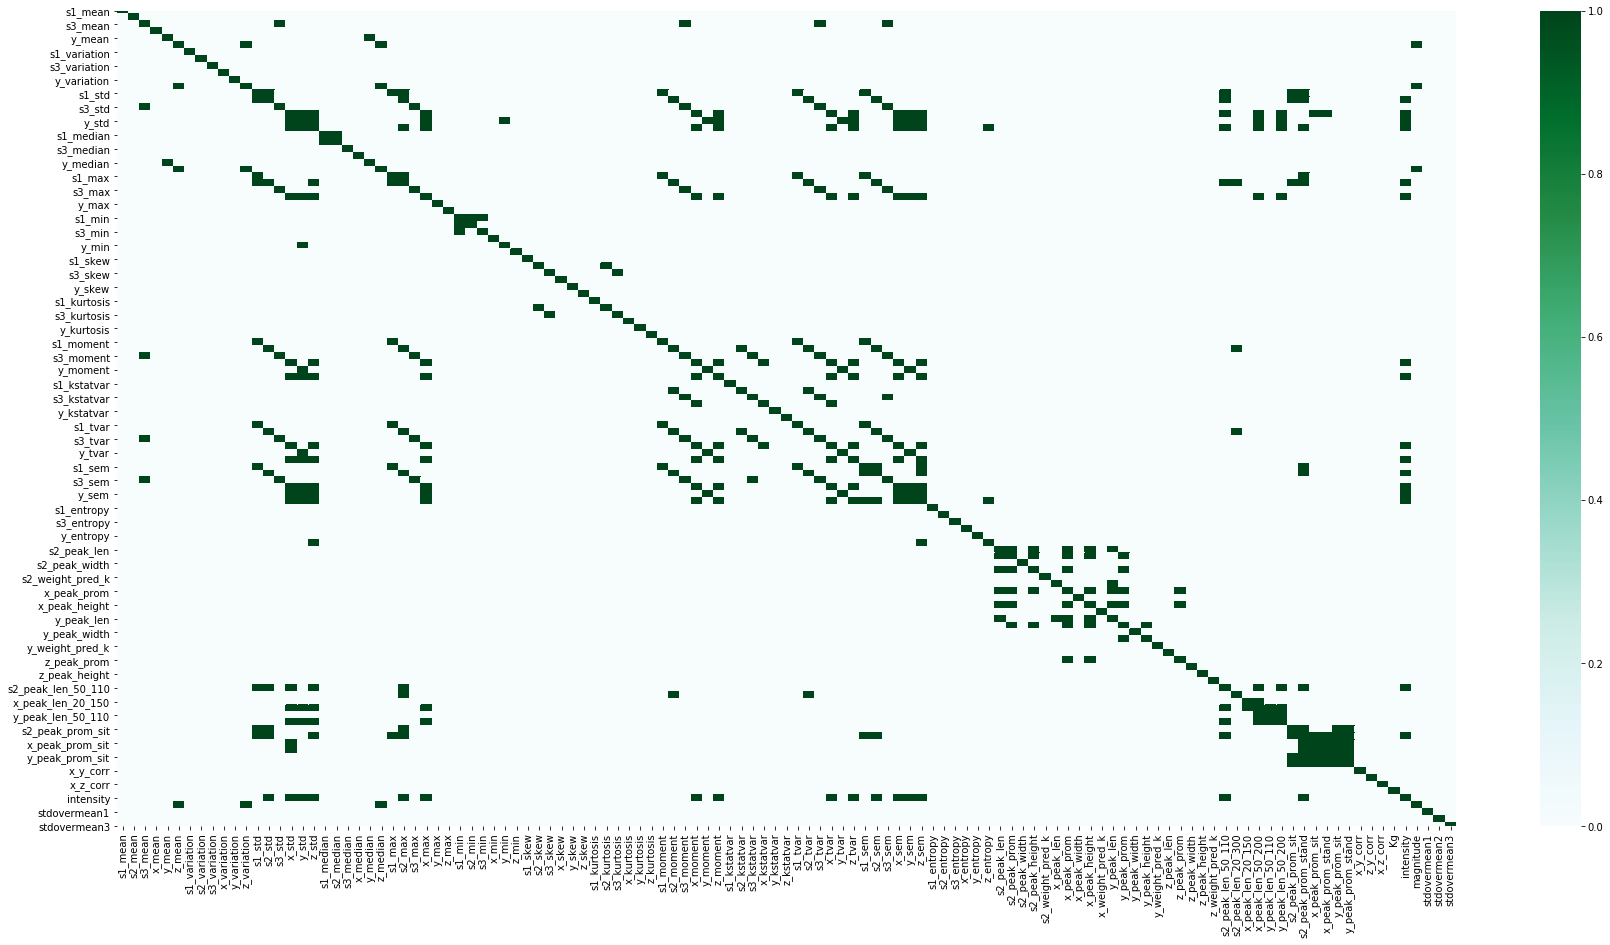

In [11]:
plt.figure(figsize=(30,15))
sns.heatmap(data.corr().abs()>=0.75, cmap = "BuGn")
plt.show()


In [71]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:", data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index([], dtype='object')


In [72]:
#the benchmark for Target 
data.Target.value_counts(normalize=True).mul(100).rename("Target percentage")

Mixed walking                         26.121262
Walking                               26.121262
Sitting                               10.672757
Standing                               9.593023
Jogging                                8.098007
Climbing down                          5.481728
Climbing up                            4.983389
Stairs up                              4.360465
Stairs down                            2.657807
Mixed walking  with little pauses      0.789037
Mixed walking  includes stairs up      0.622924
No activity                            0.498339
Name: Target percentage, dtype: float64

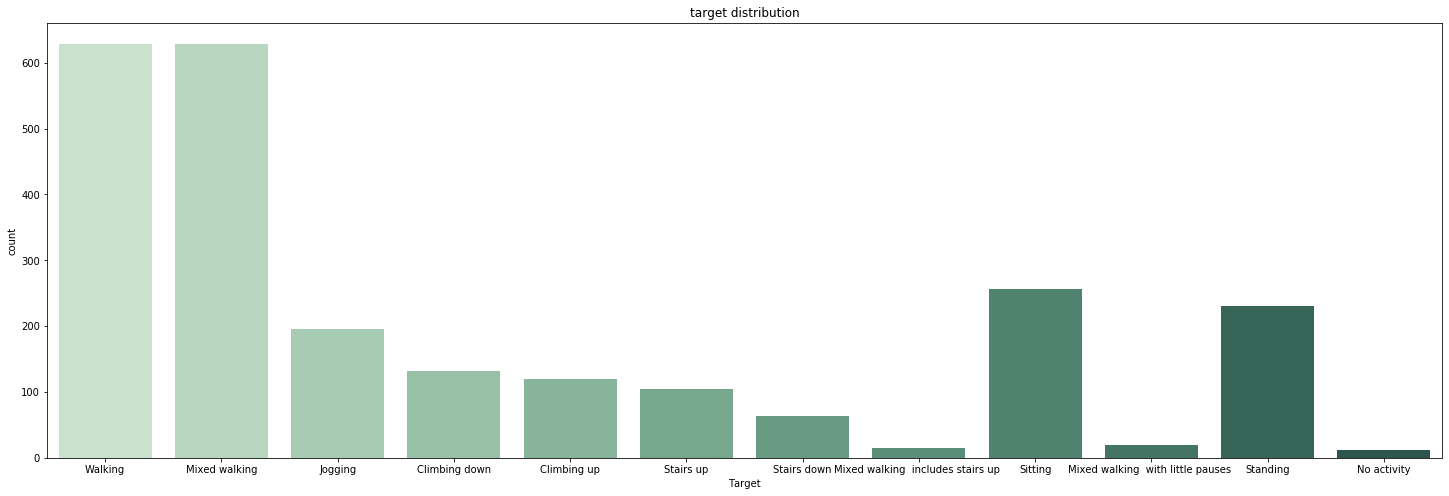

In [73]:
#the distribution of target
plt.figure(figsize=(25,8))
sns.countplot(data.Target, palette="ch:2.5,-.2,dark=.3")
plt.title("target distribution")
plt.show()

In [74]:
data['Target'].tail(100)


2308    Mixed walking
2309    Mixed walking
2310    Mixed walking
2311    Mixed walking
2312    Mixed walking
            ...      
2403          Sitting
2404          Sitting
2405          Sitting
2406          Sitting
2407          Sitting
Name: Target, Length: 100, dtype: object

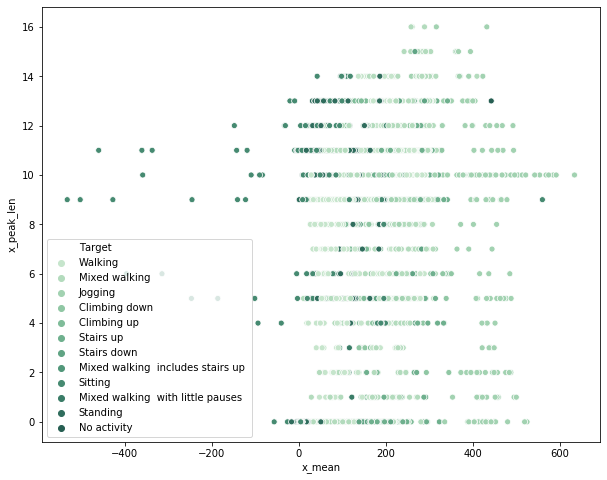

In [75]:
plt.figure(figsize=(10,8))
a = sns.scatterplot(x="x_mean", y="x_peak_len", hue="Target",palette="ch:2.5,-.2,dark=.3"
                     , data=data)


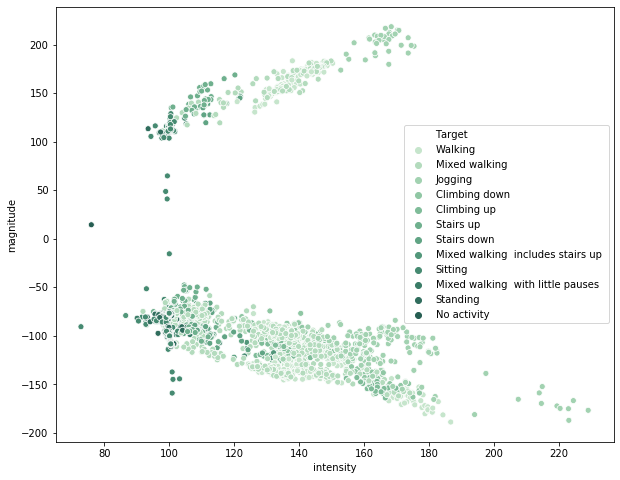

In [76]:
plt.figure(figsize=(10,8))
b=  sns.scatterplot(x="intensity", y="magnitude", hue="Target", palette="ch:2.5,-.2,dark=.3",
                     data=data)

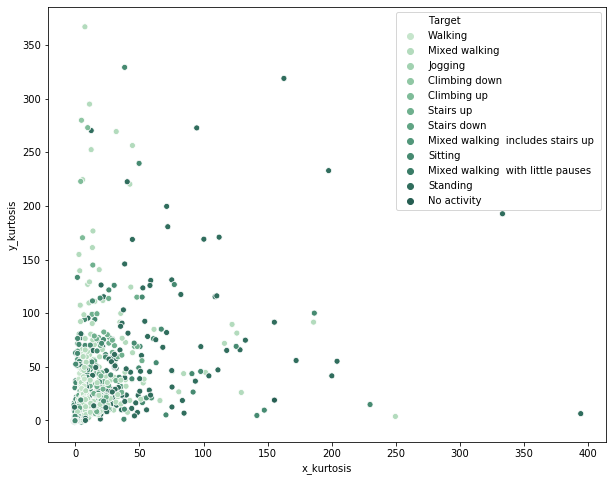

In [77]:
plt.figure(figsize=(10,8))
b=  sns.scatterplot(x="x_kurtosis",y="y_kurtosis", hue="Target", palette="ch:2.5,-.2,dark=.3",
                     data=data)

In [78]:
data.corr().to_csv('out.csv')


In [79]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# Drop features 
data= data.drop(data[to_drop], axis=1)


In [80]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 0 to 2407
Data columns (total 61 columns):
s1_mean              2408 non-null float64
s2_mean              2408 non-null float64
s3_mean              2408 non-null float64
x_mean               2408 non-null float64
y_mean               2408 non-null float64
z_mean               2408 non-null float64
s1_variation         2408 non-null float64
s2_variation         2408 non-null float64
s3_variation         2408 non-null float64
x_variation          2408 non-null float64
y_variation          2408 non-null float64
s1_std               2408 non-null float64
x_std                2408 non-null float64
s1_median            2408 non-null float64
s3_median            2408 non-null float64
x_median             2408 non-null float64
y_max                2408 non-null int64
z_max                2408 non-null int64
s1_min               2408 non-null int64
x_min                2408 non-null int64
z_min                2408 non-null int64


In [81]:
data['Target'] = np.where((data['Target']=='Sitting') | (data['Target']=='Standing') | (data['Target']=='No activity'), 1, 0)


In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 0 to 2407
Data columns (total 61 columns):
s1_mean              2408 non-null float64
s2_mean              2408 non-null float64
s3_mean              2408 non-null float64
x_mean               2408 non-null float64
y_mean               2408 non-null float64
z_mean               2408 non-null float64
s1_variation         2408 non-null float64
s2_variation         2408 non-null float64
s3_variation         2408 non-null float64
x_variation          2408 non-null float64
y_variation          2408 non-null float64
s1_std               2408 non-null float64
x_std                2408 non-null float64
s1_median            2408 non-null float64
s3_median            2408 non-null float64
x_median             2408 non-null float64
y_max                2408 non-null int64
z_max                2408 non-null int64
s1_min               2408 non-null int64
x_min                2408 non-null int64
z_min                2408 non-null int64


In [83]:
data=pd.get_dummies(data, drop_first=True)


In [84]:
#sepparating data
Y=data["Target"]
X=data.drop("Target",axis=1)

In [85]:
#adding constant
X=sm.add_constant(X)


In [86]:
#splitting the data
#split Y into two parts - get Y0, Y1 
#split X into two parts - get X0, Y0 
#X1,Y1-> test, X0, Y0-> train
Y1=Y[:217]
Y0=Y[-2191:]
X1=X[:217]
X0=X[-2191:]

In [87]:
model=Logit(Y0,X0)
results=model.fit()

Optimization terminated successfully.
         Current function value: 0.036329
         Iterations 14


In [88]:
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Target   No. Observations:                 2191
Model:                          Logit   Df Residuals:                     2124
Method:                           MLE   Df Model:                           66
Date:                Sat, 16 May 2020   Pseudo R-squ.:                  0.9295
Time:                        09:46:13   Log-Likelihood:                -79.596
converged:                       True   LL-Null:                       -1128.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.9214   1.87e+07  -4.93e-08      1.000   -3.66e+07    3.66e+07
s1_mean               0.0684      0.049      1.406      0.160      -0.027       0.164
s2_mean               0.0653      0.038      1.739      0.082      -0.008       0.139
s3_mean              -0.1405      0.037     -3.816      0.000      -0.213      -0.068
x_mean               -0.0814      0.021     -3.855      0.000      -0.123      -0.040
y_mean                0.0087      0.011      0.772      0.440      -0.013       0.031
z_mean                0.0011      0.006      0.183      0.855      -0.011       0.013
s1_variation         -0.0085      0.021     -0.395      0.693      -0.051       0.034
s2_variation         -0.0593      0.135     -0.441      0.659      -0.323       0.205
s3_variation         -0.1022      0.053     -1.943      0.052      -0.205       0.001
x_variation           0.0053      0.015      0.341      0.733      -0.025       0.036
y_variation          -0.0530      0.028     -1.909      0.056      -0.107       0.001
s1_std               -0.0763      0.031     -2.466      0.014      -0.137      -0.016
x_std                -0.0067      0.004     -1.775      0.076      -0.014       0.001
s1_median            -0.0464      0.032     -1.451      0.147      -0.109       0.016
s3_median             0.0631      0.031      2.047      0.041       0.003       0.124
x_median              0.0125      0.017      0.753      0.451      -0.020       0.045
y_max                 0.0003      0.001      0.622      0.534      -0.001       0.001
z_max                -0.0004      0.001     -0.608      0.543      -0.002       0.001
s1_min                0.0180      0.035      0.509      0.611      -0.051       0.087
x_min                 0.0012      0.001      1.364      0.172      -0.001       0.003
z_min                 0.0006      0.000      1.462      0.144      -0.000       0.001
s1_skew               0.7133      0.571      1.250      0.211      -0.405       1.832
s2_skew               0.5594      0.530      1.056      0.291      -0.479       1.598
s3_skew              -0.4704      0.447     -1.051      0.293      -1.347       0.406
x_skew               -0.0714      0.076     -0.935      0.350      -0.221       0.078
y_skew               -0.1199      0.078     -1.537      0.124      -0.273       0.033
z_skew                0.0032      0.049      0.065      0.948      -0.093       0.100
s1_kurtosis          -0.1687      0.150     -1.125      0.261      -0.463       0.125
x_kurtosis           -0.0039      0.006     -0.661      0.509      -0.016       0.008
y_kurtosis           -0.0074      0.006     -1.211      0.226      -0.019       0.005
z_kurtosis            0.0020      0.004      0.540      0.589      -0.005       0.009
s1_kstatvar       -1.715e-06   1.03e-06     -1.667      0.096   -3.73e-06    3.01e-07
y_kstatvar         8.394e-11   6.06e-11      1.385      0.166   -3.48e-11    2.03e-10
z_kstatvar         2.519e-11   4.61e-11      0.546      0.5

In [89]:
results.get_margeff().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 Target
Method:                          dydx
At:                           overall
=====================================================================================
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
s1_mean               0.0007      0.001      1.492      0.136      -0.000       0.002
s2_mean               0.0007      0.000      1.573      0.116      -0.000       0.002
s3_mean              -0.0015      0.000     -4.222      0.000      -0.002      -0.001
x_mean               -0.0009      0.000     -3.485      0.000      -0.001      -0.000
y_mean             9.462e-05      0.000      0.773      0.439      -0.000       0.000
z_mean             1.205e-05   6.59e-05      0.183      0.855      -0.000       0.000
s1_variation      -9.268e-05      0.000     -0.406      0.684      -0.001       0.000
s2_variation         -0.0006      0.002     -0.403      0.687      -0.004       0.003
s3_variation         -0.0011      0.001     -1.962      0.050      -0.002   -8.89e-07
x_variation        5.767e-05      0.000      0.336      0.737      -0.000       0.000
y_variation          -0.0006      0.000     -1.979      0.048      -0.001   -5.66e-06
s1_std               -0.0008      0.000     -2.518      0.012      -0.001      -0.000
x_std             -7.305e-05   3.96e-05     -1.843      0.065      -0.000    4.63e-06
s1_median            -0.0005      0.000     -1.458      0.145      -0.001       0.000
s3_median             0.0007      0.000      2.101      0.036    4.64e-05       0.001
x_median              0.0001      0.000      0.727      0.467      -0.000       0.001
y_max              3.823e-06   6.16e-06      0.621      0.535   -8.25e-06    1.59e-05
z_max             -3.882e-06   6.43e-06     -0.603      0.546   -1.65e-05    8.73e-06
s1_min                0.0002      0.000      0.506      0.613      -0.001       0.001
x_min              1.274e-05   9.38e-06      1.358      0.174   -5.65e-06    3.11e-05
z_min              6.593e-06   4.54e-06      1.454      0.146    -2.3e-06    1.55e-05
s1_skew               0.0078      0.006      1.281      0.200      -0.004       0.020
s2_skew               0.0061      0.006      1.031      0.302      -0.006       0.018
s3_skew              -0.0051      0.005     -1.049      0.294      -0.015       0.004
x_skew               -0.0008      0.001     -0.950      0.342      -0.002       0.001
y_skew               -0.0013      0.001     -1.510      0.131      -0.003       0.000
z_skew             3.506e-05      0.001      0.065      0.948      -0.001       0.001
s1_kurtosis          -0.0018      0.002     -1.069      0.285      -0.005       0.002
x_kurtosis        -4.304e-05   6.47e-05     -0.665      0.506      -0.000    8.38e-05
y_kurtosis        -8.036e-05   6.67e-05     -1.206      0.228      -0.000    5.03e-05
z_kurtosis         2.214e-05   4.08e-05      0.543      0.587   -5.78e-05       0.000
s1_kstatvar       -1.873e-08   1.09e-08     -1.714      0.087   -4.01e-08    2.69e-09
y_kstatvar         9.168e-13   6.61e-13      1.388      0.165   -3.78e-13    2.21e-12
z_kstatvar         2.751e-13   5.05e-13      0.545      0.586   -7.14e-13    1.26e-12
s1_entropy           -0.0032      0.002     -1.369      0.171      -0.008       0.001
s2_entropy           -0.0024      0.002     -1.250      0.211      -0.006       0.001
s3_entropy           -0.0017      0.002     -0.983      0.325      -0.005       0.002
x_entropy             0.0008      0.002      0.547      0.584      -0.002       0.004
y_entropy             0.0022      0.002      1.168      0.243      -0.001       0.006
s2_peak_len          -0.0046      0.002     -2.315      0.021      -0.009      -0.001
s2_peak_width        -0.0008      0.001     -1.413      0.158   

In [90]:
results.pred_table().T


array([[1709.,   13.],
       [  20.,  449.]])

In [91]:
results.pred_table(0.7).T


array([[1721.,   25.],
       [   8.,  437.]])

In [92]:
Y1_hat=results.predict(X1)
Y0_hat=results.predict(X0)


In [93]:
Y1_class=np.where(Y1_hat>=0.5,1,0)
Y0_class=np.where(Y0_hat>=0.5,1,0)

In [94]:
print("ROC_AUC Train:",roc_auc_score(Y0,Y0_hat).round(2))
print("ROC_AUC Test:",roc_auc_score(Y1,Y1_hat).round(2))

ROC_AUC Train: 1.0
ROC_AUC Test: 0.97


In [95]:
#confusion matrix for the train data
cm_train=confusion_matrix(Y0,Y0_class).T

In [96]:
print("Accuracy_train:", (cm_train[0,0]+cm_train[1,1])/len(Y0))
print("Sensitivity_train:",cm_train[1,1]/(cm_train[1,1]+cm_train[0,1]))
print("Specificity_train:",cm_train[0,0]/(cm_train[0,0]+cm_train[1,0]))

Accuracy_train: 0.9849383842994066
Sensitivity_train: 0.9718614718614719
Specificity_train: 0.9884326200115674


In [97]:
#confusion matrix for the test data
cm_test=confusion_matrix(Y1,Y1_class).T

In [98]:
#let's calculate overall accuracy, recall and specificity for test data
print("Accuracy_test:", (cm_test[0,0]+cm_test[1,1])/len(Y1))
print("Sensitivity_test:",cm_test[1,1]/(cm_test[1,1]+cm_test[0,1]))
print("Specificity_test:",cm_test[0,0]/(cm_test[0,0]+cm_test[1,0]))

Accuracy_test: 0.9493087557603687
Sensitivity_test: 0.9210526315789473
Specificity_test: 0.9553072625698324


In [99]:
#calculating using classification report
print("Logistic Regression Train:")
print(classification_report(Y0,Y0_class))

print("Logistic Regression Test:")
print(classification_report(Y1,Y1_class))

Logistic Regression Train:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1729
           1       0.96      0.97      0.96       462

    accuracy                           0.98      2191
   macro avg       0.97      0.98      0.98      2191
weighted avg       0.99      0.98      0.98      2191

Logistic Regression Test:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       179
           1       0.81      0.92      0.86        38

    accuracy                           0.95       217
   macro avg       0.90      0.94      0.92       217
weighted avg       0.95      0.95      0.95       217



In [100]:
#Note that we can also calculate accuracy, recall and ROC_AUC score using respective metrics from sklearn library
#summarizing the results into a dataframe
results_summary=pd.DataFrame({"Accuracy":[accuracy_score(Y0,Y0_class),accuracy_score(Y1,Y1_class)],
                              "ROC_AUC":[roc_auc_score(Y0,Y0_hat),roc_auc_score(Y1, Y1_hat)],
                              "Recall":[recall_score(Y0, Y0_class),recall_score(Y1, Y1_class)]
                              },
                             index=["Training set","Testing set"])
results_summary

,Accuracy,ROC_AUC,Recall
Training set,0.984938,0.998736,0.971861
Testing set,0.949309,0.971626,0.921053


In [101]:
dt=DecisionTreeClassifier(random_state=1)
dt.fit(X0,Y0)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [102]:
#calculating probabilities
Y0_dt=dt.predict_proba(X0)[:,1]
Y1_dt=dt.predict_proba(X1)[:,1]

In [103]:
#setting up parameters for DT's GridSearch
param_dt={"max_depth":range(1,15),
          "min_samples_leaf":range(10,150,10),
          "class_weight":["balanced",None]        
            }

In [104]:
#fitting GridSearch with above specified parameters
gs_dt=GridSearchCV(estimator=DecisionTreeClassifier(random_state=1), param_grid=param_dt,
                  scoring="roc_auc",cv=5)
gs_dt.fit(X0,Y0)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=1,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': range(1, 15),
                         '

In [105]:
gs_dt.best_params_


{'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 60}

In [106]:
#fitting the model with best parameters
dt_grid=DecisionTreeClassifier(class_weight='balanced',max_depth=4,min_samples_leaf=60, random_state=1).fit(X0,Y0)

In [107]:
Y0_dt_grid=dt_grid.predict_proba(X0)[:,1]
Y1_dt_grid=dt_grid.predict_proba(X1)[:,1]
print("ROC_AUC Train for tuned DT:",roc_auc_score(Y0,Y0_dt_grid).round(2))
print("ROC_AUC Test for tuned DT:",roc_auc_score(Y1,Y1_dt_grid).round(2))
print("Mean 5-fold ROC AUC score for Tuned DT",np.mean(cross_val_score(estimator=dt_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

ROC_AUC Train for tuned DT: 0.99
ROC_AUC Test for tuned DT: 0.96
Mean 5-fold ROC AUC score for Tuned DT 0.97


In [108]:
#building GridSearch with Logistic Regression
logit=LogisticRegression(random_state=1)

param_logit={"class_weight":["balanced",None],
            "C":np.linspace(0.0001,50,20)}


gs_logit=GridSearchCV(estimator=logit,
                      param_grid=param_logit,
                      scoring="roc_auc", cv=5, verbose=1, n_jobs=2).fit(X0,Y0) 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    5.2s finished


In [109]:
#finding out the best parameters
gs_logit.best_params_

{'C': 0.0001, 'class_weight': None}

In [110]:
#building logit with best params and seeing the results
logit_grid=LogisticRegression(C=0.0001,class_weight='balanced',random_state=1).fit(X0,Y0)

Y0_logit=logit_grid.predict_proba(X0)[:,1]
Y1_logit=logit_grid.predict_proba(X1)[:,1]
print("ROC_AUC Train for tuned Logit:",roc_auc_score(Y0,Y0_logit).round(2))
print("ROC_AUC Test for tuned Logit:",roc_auc_score(Y1,Y1_logit).round(2))
print("Mean 5-fold ROC AUC score for Tuned Logit",np.mean(cross_val_score(estimator=logit_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

ROC_AUC Train for tuned Logit: 0.97
ROC_AUC Test for tuned Logit: 0.99
Mean 5-fold ROC AUC score for Tuned Logit 0.97


In [111]:
print(param_dt)


{'max_depth': range(1, 15), 'min_samples_leaf': range(10, 150, 10), 'class_weight': ['balanced', None]}


In [112]:
#building GridSearch for RF using DT's hyperparameters ranges
gs_rf=GridSearchCV(estimator=RandomForestClassifier(random_state=1),
                  param_grid=param_dt, scoring="roc_auc", cv=3, n_jobs=2).fit(X0,Y0)

In [113]:
#outlining best parameters
gs_rf.best_params_

{'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 20}

In [121]:
#building RF with the best parameters
rf_grid=RandomForestClassifier(class_weight=None,max_depth=4,min_samples_leaf=20, random_state=1).fit(X0,Y0)

Y0_rf_grid=rf_grid.predict_proba(X0)[:,1]
Y1_rf_grid=rf_grid.predict_proba(X1)[:,1]
print("ROC_AUC Train for tuned Logit:",roc_auc_score(Y0,Y0_rf_grid).round(2))
print("ROC_AUC Test for tuned Logit:",roc_auc_score(Y1,Y1_rf_grid).round(2))
print("Mean 5-fold ROC AUC score for Tuned RF",np.mean(cross_val_score(estimator=rf_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

ROC_AUC Train for tuned Logit: 0.99
ROC_AUC Test for tuned Logit: 0.99
Mean 5-fold ROC AUC score for Tuned RF 0.98


In [122]:
#As we see, Random Forest outperforms the two other models on mean 5-fold cross validation score.

print("Mean 5-fold ROC AUC score for Tuned DT",np.mean(cross_val_score(estimator=dt_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))
print("Mean 5-fold ROC AUC score for Tuned RF",np.mean(cross_val_score(estimator=rf_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))
print("Mean 5-fold ROC AUC score for Tuned Logit",np.mean(cross_val_score(estimator=logit_grid,X=X,y=Y,cv=5, scoring="roc_auc")).round(2))

Mean 5-fold ROC AUC score for Tuned DT 0.97
Mean 5-fold ROC AUC score for Tuned RF 0.98
Mean 5-fold ROC AUC score for Tuned Logit 0.97


###ROC Curve, Gain and Lift charts for winning model

In [123]:
#setting up the needed metrics
FPR, TPR, thresholds=roc_curve(Y1, logit_grid.predict_proba(X1)[:,1])

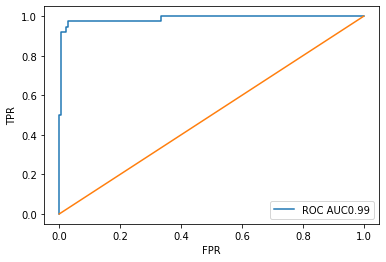

In [124]:
#plotting ROC AUC for Logistic Regression
plt.plot(FPR, TPR, label=f"ROC AUC{roc_auc_score(Y1,logit_grid.predict_proba(X1)[:,1]).round(2)}")
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [125]:
#gain and lift curve plots for the Logistic Regression

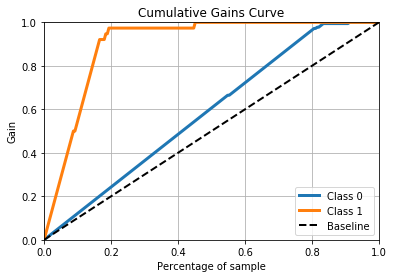

In [126]:
skplt.metrics.plot_cumulative_gain(Y1,logit_grid.predict_proba(X1))
plt.show()

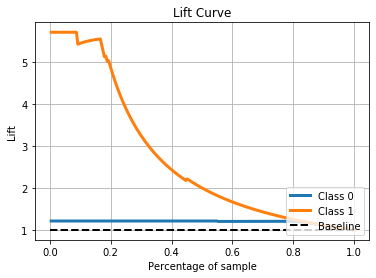

In [127]:
skplt.metrics.plot_lift_curve(Y1,logit_grid.predict_proba(X1))
plt.show()